In [2]:
from ctypes import sizeof
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pickle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_dataset():
  image_pickle_file_path = '/content/drive/MyDrive/phase_1/images.pkl'
  label_pickle_file_path = '/content/drive/MyDrive/phase_1/label (1).pkl'

  with open(image_pickle_file_path, 'rb') as file:
    images = pickle.load(file)

  with open(label_pickle_file_path, 'rb') as file:
    labels = pickle.load(file)

  images = images.reshape(images.shape[0], -1)
  print(images.shape)

  return images, labels

In [ ]:
images, labels = load_dataset()

(560, 747003)


##Classification

In [4]:
# Classify the datapoints with the Random Forest Classifier

def classify(datapoints, labels):
  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(datapoints, labels, test_size=test_size, random_state=42)

  clf = RandomForestClassifier(n_estimators=100, random_state=42)

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy * 100:.2f}%")
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
  disp.plot()
  plt.show()
  precision, recall, f1_score = accuracy_metrics(y_test, y_pred)
  print(f"Precision:", precision)
  print(f"Recall: ", recall)
  print(f"F1-score:", f1_score)
  return  X_test, y_test, y_pred

In [ ]:
classify(images, labels)

In [6]:
def accuracy_metrics(y_true, y_pred):
    tp = np.sum(y_true & y_pred)
    fp = np.sum(y_pred & ~np.array(y_true))
    precision = tp / (tp + fp)
    tp = np.sum(y_true & y_pred)
    fn = np.sum(y_true & ~y_pred)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

##DBSCAN

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pickle
from sklearn.cluster import DBSCAN

def dbscan(img, eps, min_samples):
    # Get image dimensions
    height, width, _ = img.shape

    # Generate x and y coordinates
    x, y = np.meshgrid(np.abs(np.arange(width) - np.full(width, width/2)), np.abs(np.arange(height) - np.full(height, height/2)))
    x = x.flatten()
    y = y.flatten()
    # print(height, width)
    # print(x[0], y[0])

    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h = img[:,:,0]
    s = img[:,:,1]
    r = img[:,:,2]
    h_color = h.reshape((-1, 1))
    s_color = s.reshape((-1, 1))
    r_color = r.reshape((-1, 1))
    # z_color = img.reshape((-1, 3))

    z_coordinates = np.column_stack((x, y))
    # Z = np.column_stack((h_color, h_color, h_color, h_color, s_color, s_color, r_color, z_coordinates))
    Z = np.column_stack((h_color,s_color,r_color, ))
    print(Z.shape)


    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(Z)



    # Assign labels to clusters
    labels = clustering.labels_

    print("davies_bouldin_score",metrics.davies_bouldin_score(Z, labels))
    print("calinski_harabasz_score",metrics.calinski_harabasz_score(Z, labels))

    # Reshape the labels to match the image dimensions
    res = labels.reshape((height, width))
    print(res.shape)

    return res

data = pickle.load(open('/content/drive/MyDrive/phase_1/images.pkl', 'rb'))

# Set DBSCAN parameters
eps = 700  # Epsilon (maximum distance between two samples)
min_samples = 50  # Minimum number of samples in a neighborhood

for i in range(10):
    img = data[i]
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    # Apply DBSCAN clustering
    res2 = dbscan(img, eps, min_samples)
    # res2 = cv.cvtColor(res2, cv.COLOR_HSV2RGB)
    # Display the result
    plt.imshow(res2)
    plt.show()

##K-Means

In [7]:
def kmean(img, K):

    height, width, _ = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    x, y = np.meshgrid(np.abs(np.arange(width) - np.full(width, width / 2)),
                       np.abs(np.arange(height) - np.full(height, height / 2)))
    x = x.flatten()
    y = y.flatten()
    h = img[:, :, 0]
    s = img[:, :, 1]
    r = img[:, :, 2]
    h_color = h.reshape((-1, 1))
    s_color = s.reshape((-1, 1))
    r_color = r.reshape((-1, 1))

    z_coordinates = np.column_stack((x, y))

    Z = np.column_stack((2*h_color, 2*h_color, h_color, 1.5*s_color, 1.5*s_color, 1.5*r_color, r_color, z_coordinates))

    # Convert Z to float32
    Z = np.float32(Z)

    # Set K-means criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Perform K-means clustering
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)


    # Convert center to uint8
    center = np.uint8(center)

    # Extract cluster colors
    res = center[label.flatten()]
    res2 = res.reshape((height, width, 9))[:, :, :3]

    # Calculate DST metric for clustering performance
    # labels = label.reshape(res2.shape[:2])
    # STD = 0
    # for cluster_id in range(K):
    #   h = (img[:, :, 0][labels == cluster_id])
    #   STD += np.std(h)
    # print("DST Metric:", STD)

    #  # Calculate Davies-Bouldin Index
    # print("davies_bouldin_score:", metrics.davies_bouldin_score(Z, label))


    return res2, label, center

##Feature Extraction

In [ ]:
data = pickle.load(open('/content/drive/MyDrive/phase_1/images.pkl', 'rb'))
labels = pickle.load(open('/content/drive/MyDrive/phase_1/label (1).pkl', 'rb'))

num_images = len(data)
random_indices = np.random.choice(num_images, 280, replace=False)

# Convert random_indices to a list before indexing
random_indices = list(random_indices)
images_subset = data[random_indices]
labels_subset = []

# Iterate over the random indices and extract the corresponding labels
for index in random_indices:
    labels_subset.append(labels[index])
print(len(images_subset))

region_vectors = []
image_features = []

K = 5

for i in range(len(images_subset)):
    print("image:", i)
    img = images_subset[i]
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display original image
    # plt.imshow(img1)
    # plt.show()

    # Perform K-means clustering and extract features
    res2, label, center = kmean(img, K)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Convert clustered image back to RGB
    res2 = cv2.cvtColor(res2, cv2.COLOR_HSV2RGB)

    # Display clustered image
    # plt.imshow(res2)
    # plt.show()

    # Initialize empty list for cluster features
    cluster_features = []

    # Reshape label array to match res2 dimensions
    label = label.reshape(res2.shape[:2])

    for cluster_id in range(K):
    # Extract features for the current cluster
        h = (img[:, :, 0][label == cluster_id])/ 180
        s = (img[:, :, 1][label == cluster_id]) / 255
        r = (img[:, :, 2][label == cluster_id]) / 255
        filtered_label = label[label == cluster_id]
        # Check if the cluster is empty
        if len(h) > 1:
            # Calculate the color mean and std for h, s, and r
            center_cluster = center[filtered_label]
            cluster_mean_h = np.mean(h)
            cluster_std_h = np.std(h)
            cluster_mean_s = np.mean(s)
            cluster_std_s = np.std(s)
            cluster_mean_r = np.mean(r)
            cluster_std_r = np.std(r)
            # Check if the mean and standard deviation are valid (not NaN)
            if not np.isnan(cluster_mean_h) and not np.isnan(cluster_std_h):
                # Calculate cluster skewness and kurtosis and spatial features
                cluster_skew_h, cluster_kurt_h = cv2.meanStdDev(h)
                cluster_skew_s, cluster_kurt_s = cv2.meanStdDev(s)
                cluster_skew_r, cluster_kurt_r = cv2.meanStdDev(r)


                pixel = len(h)
                bounding_box = cv2.boundingRect(center_cluster)
                bounding_box_width = bounding_box[2]
                bounding_box_height = bounding_box[3]
                area = bounding_box_width * bounding_box_height
                perimeter = 2 * (bounding_box_width + bounding_box_height)
                moments = cv2.moments(center_cluster)
                mu20 = moments['m20']
                mu02 = moments['m02']
                orientation = np.arctan2(moments['mu11'], moments['mu20'])


                x = [cluster_mean_h, cluster_mean_h, cluster_mean_h,
                                      cluster_std_h, cluster_std_h,
                                      cluster_skew_h[0][0], cluster_kurt_h[0][0],
                                      cluster_mean_s, cluster_std_s,
                                      cluster_mean_r, cluster_std_r]
                region_vectors.append(x)
                cluster_features.append(x)
            else:
                cluster_skew_h = np.nan
                cluster_kurt_h = np.nan
    image_features.append(cluster_features)

print("region_vectors",region_vectors)
print("image_features",image_features)
image_features = np.array(image_features, dtype=np.float32)
region_vectors = np.array(region_vectors, dtype=np.float32)

##Clustering Features

In [9]:
# Cluster all the region vectors
kmeans = KMeans(n_clusters=82)
kmeans.fit(region_vectors)
cluster_labels = kmeans.labels_

# Find the cluster of each vector
cluster_members = []
for i in range(kmeans.n_clusters):
    cluster_members.append(region_vectors[cluster_labels == i])

# Construct a histogram of the features for each image
image_vectors = []
for i, image in enumerate(image_features):
    image_vectors.append([0] * kmeans.n_clusters)
    for im_vector in image:
      for j, cluster in enumerate(cluster_members):
        for cl_vector in cluster:
          if np.all(im_vector == cl_vector):
            image_vectors[i][j] += 1

print("feature_vector",image_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


feature_vector [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

(210, 70)
(210,)
Accuracy: 71.43%


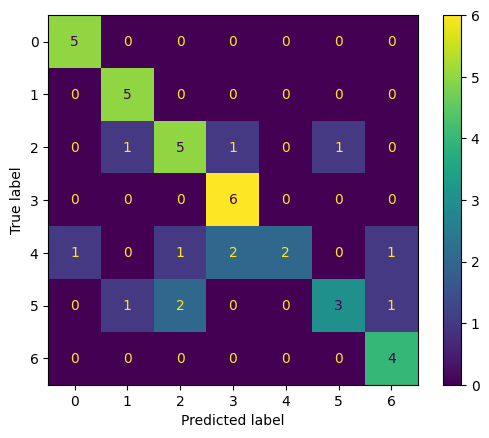

Precision: 0.7982456140350878
Recall:  0.7222222222222222
F1-score: 0.7583333333333333


In [ ]:
print(np.array(image_vectors).shape)
print(np.array(labels_subset).shape)

x, yt, yp = classify(image_vectors, labels_subset)

(210, 71)
(210,)
Accuracy: 73.81%


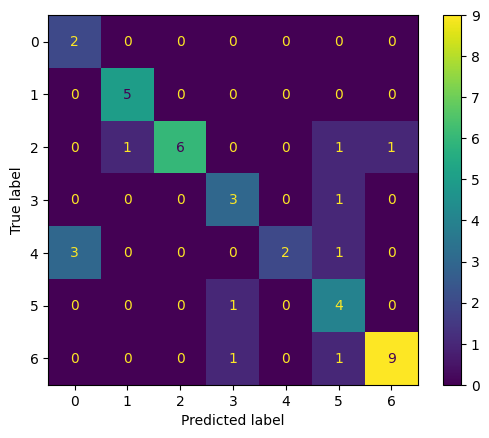

Precision: 0.8652482269503546
Recall:  0.8133333333333334
F1-score: 0.8384879725085911


In [47]:
print(np.array(image_vectors).shape)
print(np.array(labels_subset).shape)

x, yt, yp = classify(image_vectors, labels_subset)

##Plot the Mistakes

4 0
4 0
4 0
image: 4


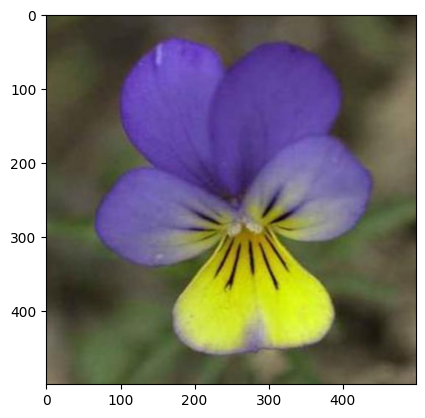

image: 4


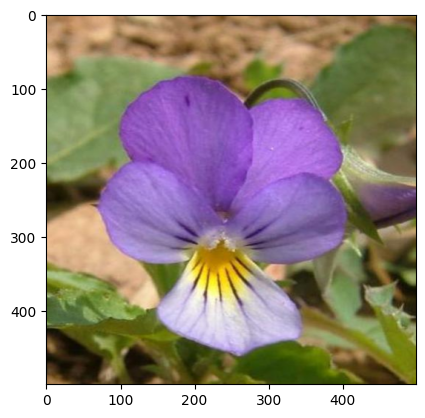

image: 4


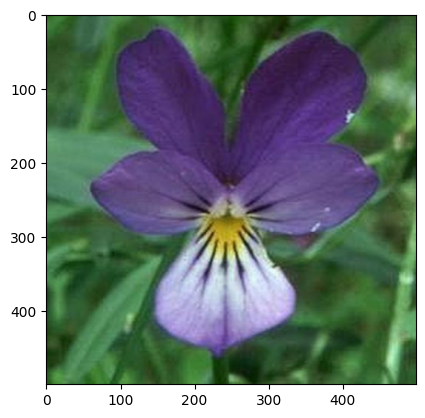

image: 0


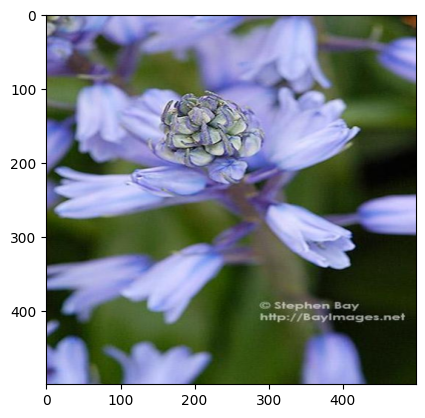

image: 0


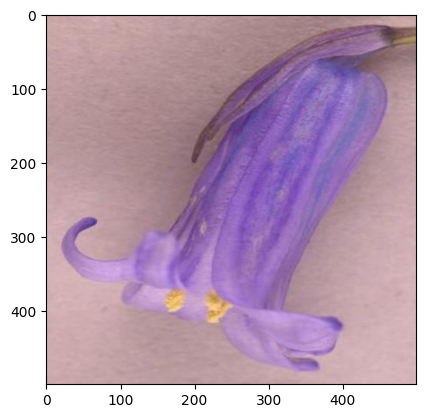

image: 0


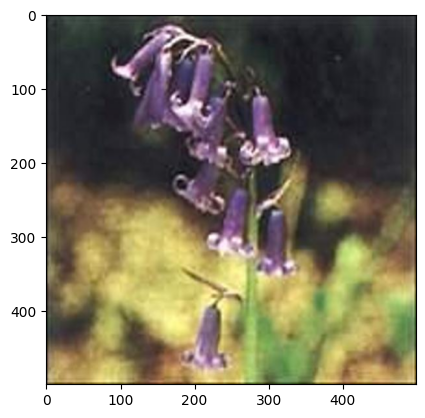

image: 0


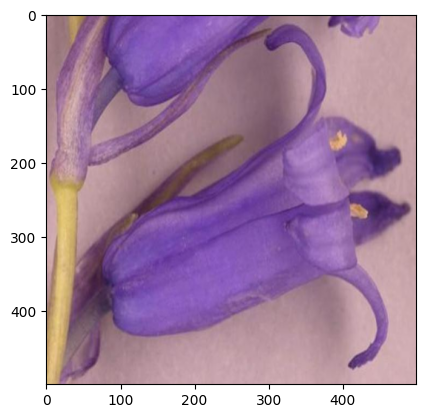

image: 0


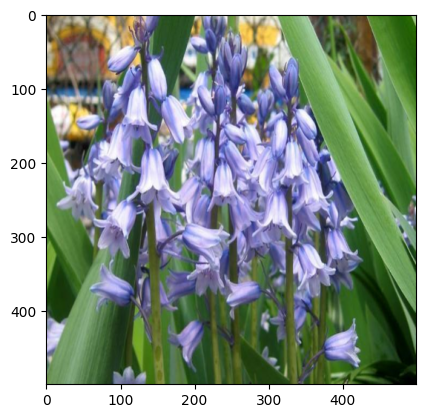

image: 0


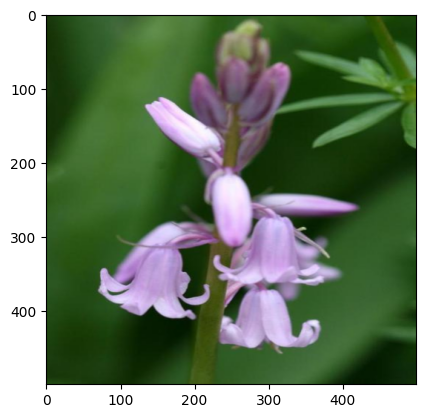

image: 0


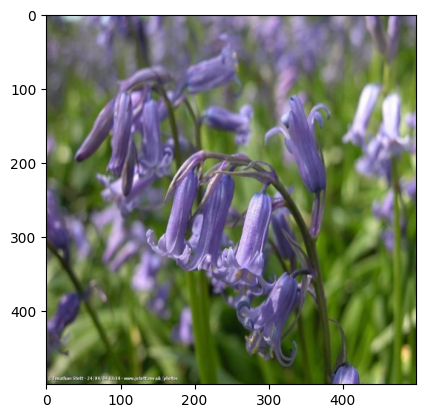

image: 0


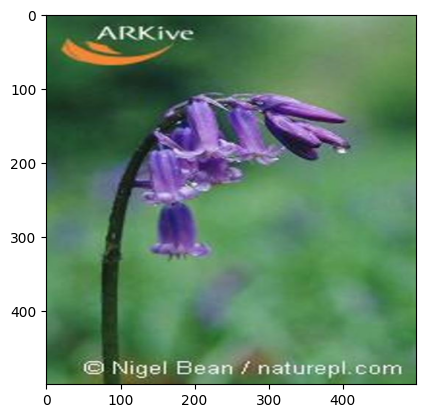

image: 0


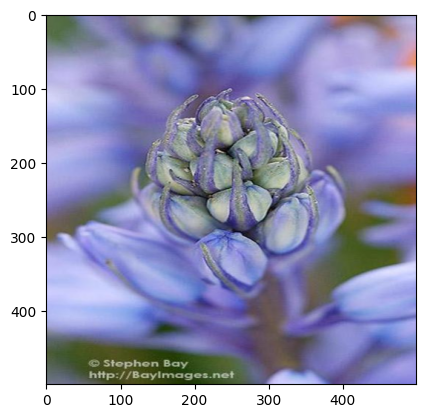

In [44]:
mistaken = []

for i in range(len(yt)):
  if(yt[i] == 4 and yp[i] == 0):
    mistaken.append(x[i])

for i  in range(len(mistaken)):
  for j, vector in enumerate(image_vectors):
    if mistaken[i] == vector:
      print("image:", labels_subset[j])
      img = images_subset[j]
      img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img1)
      plt.imshow(img1)
      plt.show()

for i in range(50):
    if labels_subset[i]==0:
      print("image:", labels_subset[i])
      img = images_subset[i]
      img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img1)
      plt.imshow(img1)
      plt.show()

##All the Dataset

In [ ]:
data = pickle.load(open('/content/drive/MyDrive/phase_1/images.pkl', 'rb'))
labels = pickle.load(open('/content/drive/MyDrive/phase_1/label (1).pkl', 'rb'))

num_images = len(data)
random_indices = np.random.choice(num_images, 280, replace=False)

# Convert random_indices to a list before indexing
random_indices = list(random_indices)
images_subset = data[random_indices]
labels_subset = []

# Iterate over the random indices and extract the corresponding labels
for index in random_indices:
    labels_subset.append(labels[index])
print(len(images_subset))

region_vectors = []
image_features = []

K = 5

for i in range(len(data)):
    print("image:", i)
    img = data[i]
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display original image
    # plt.imshow(img1)
    # plt.show()

    # Perform K-means clustering and extract features
    res2, label, center = kmean(img, K)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Convert clustered image back to RGB
    res2 = cv2.cvtColor(res2, cv2.COLOR_HSV2RGB)

    # Display clustered image
    # plt.imshow(res2)
    # plt.show()

    # Initialize empty list for cluster features
    cluster_features = []

    # Reshape label array to match res2 dimensions
    label = label.reshape(res2.shape[:2])

    for cluster_id in range(K):
    # Extract features for the current cluster
        h = (img[:, :, 0][label == cluster_id])/ 180
        s = (img[:, :, 1][label == cluster_id]) / 255
        r = (img[:, :, 2][label == cluster_id]) / 255
        filtered_label = label[label == cluster_id]
        # Check if the cluster is empty
        if len(h) > 1:
            # Calculate the color mean and std for h, s, and r
            center_cluster = center[filtered_label]
            cluster_mean_h = np.mean(h)
            cluster_std_h = np.std(h)
            cluster_mean_s = np.mean(s)
            cluster_std_s = np.std(s)
            cluster_mean_r = np.mean(r)
            cluster_std_r = np.std(r)
            # Check if the mean and standard deviation are valid (not NaN)
            if not np.isnan(cluster_mean_h) and not np.isnan(cluster_std_h):
                # Calculate cluster skewness and kurtosis and spatial features
                cluster_skew_h, cluster_kurt_h = cv2.meanStdDev(h)
                cluster_skew_s, cluster_kurt_s = cv2.meanStdDev(s)
                cluster_skew_r, cluster_kurt_r = cv2.meanStdDev(r)


                pixel = len(h)
                bounding_box = cv2.boundingRect(center_cluster)
                bounding_box_width = bounding_box[2]
                bounding_box_height = bounding_box[3]
                area = bounding_box_width * bounding_box_height
                perimeter = 2 * (bounding_box_width + bounding_box_height)
                moments = cv2.moments(center_cluster)
                mu20 = moments['m20']
                mu02 = moments['m02']
                orientation = np.arctan2(moments['mu11'], moments['mu20'])


                x = [cluster_mean_h, cluster_mean_h, cluster_mean_h,
                                      cluster_std_h, cluster_std_h,
                                      cluster_skew_h[0][0], cluster_kurt_h[0][0],
                                      cluster_mean_s, cluster_std_s,
                                      cluster_mean_r, cluster_std_r]
                region_vectors.append(x)
                cluster_features.append(x)
            else:
                cluster_skew_h = np.nan
                cluster_kurt_h = np.nan
    image_features.append(cluster_features)

print("region_vectors",region_vectors)
print("image_features",image_features)
image_features = np.array(image_features, dtype=np.float32)
region_vectors = np.array(region_vectors, dtype=np.float32)

In [ ]:
# Cluster all the region vectors
kmeans = KMeans(n_clusters=69)
kmeans.fit(region_vectors)
cluster_labels = kmeans.labels_

# Find the cluster of each vector
cluster_members = []
for i in range(kmeans.n_clusters):
    cluster_members.append(region_vectors[cluster_labels == i])

# Construct a histogram of the features for each image
image_vectors = []
for i, image in enumerate(image_features):
    image_vectors.append([0] * kmeans.n_clusters)
    for im_vector in image:
      for j, cluster in enumerate(cluster_members):
        for cl_vector in cluster:
          if np.all(im_vector == cl_vector):
            image_vectors[i][j] += 1

print("feature_vector",image_vectors)

(560, 69)
(560,)
Accuracy: 72.32%


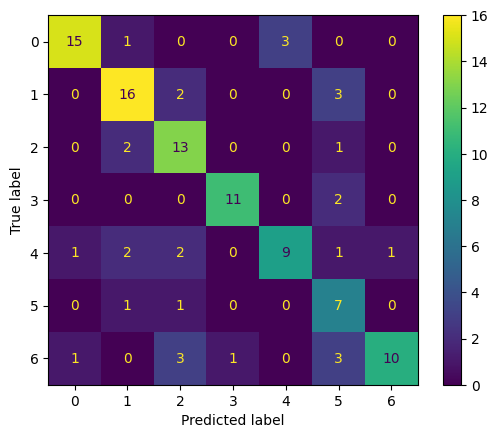

Precision: 0.802675585284281
Recall:  0.7766990291262136
F1-score: 0.7894736842105263


In [116]:
print(np.array(image_vectors).shape)
print(np.array(labels).shape)

x, yt, yp = classify(image_vectors, labels)